In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/projetdm-data/TRAIN.CSV
/kaggle/input/projetdm-data/TEST.CSV


In [50]:
train_data = "/kaggle/input/projetdm-data/TRAIN.CSV"
### Loop the data lines
with open(train_data, 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
df_train = pd.read_csv(train_data,header=None, delimiter=",", names=column_names, low_memory=False).astype(str)

In [51]:
import re
hotkey_actions_to_count = ["0","1","2"]
hotkeys_to_count = ["0","1","2","3","4","5","6","7","8","9"]

In [52]:
# cut_off: take at most the first cut_off second from every game, deafult 6 minutes
# min_game_length: remove too short games, isn't applied if is_Test is True, default 1 minute

def extract_features(input_data, is_test = False, cut_off = 6*60, min_game_length = 1*60):
    output_data = []
    for row in input_data:
        count_hotkey_actions = [0] * len(hotkey_actions_to_count)
        count_hotkeys = [0] * len(hotkeys_to_count)
        new_row = []
        new_row.append(row[0])
        new_row.append(row[1])
        game_length = 0
        count_action = 0
        
        for action in row[2:]:
            # look for time cell, begin with "t"
            if isinstance(action, str):
                match = re.match(r't(\d+)', action)
                if match:
                    time = int(match.group(1))
                    game_length = time
                    if (game_length > cut_off):
                        break

            # count 0, 1, 2 at the end of "hotkey"
            for index, substring in enumerate(hotkey_actions_to_count):
                if (action.startswith('hotkey') and action.endswith(substring)):
                    count_hotkey_actions[index] += 1

            # count hotkey
            for index, substring in enumerate(hotkeys_to_count):
                if (action.startswith('hotkey') and action[-2] == substring):
                    count_hotkeys[index] += 1
            
            if (action == 's' or action == 'Base'):
                count_action += 1
            
        # there may be more action after the last 't'
        game_length += 2
            
        # frenquency of base, mineral, other action
        count_action /= game_length
        
        new_row.append(count_action)
        
        # Calculate the frequency of hotkey
        for i in range(len(hotkey_actions_to_count)):
            count_hotkey_actions[i] /= game_length

        for i in range(len(hotkeys_to_count)):
            count_hotkeys[i] /= game_length
        
        for i in range(len(count_hotkey_actions)):
            new_row.append(count_hotkey_actions[i])
        for i in range(len(count_hotkeys)):
            new_row.append(count_hotkeys[i])
            
        if (is_test == False):
            if (game_length > min_game_length):
                output_data.append(new_row)
        else:
            output_data.append(new_row)
    return output_data

In [53]:
converted_train_data = df_train.values
output_train_data = extract_features(converted_train_data)

In [54]:
# Convert the table to a DataFrame with headers
headers = ['url', 'race', 'number_action', 'number_hotkey_created', 'number_hotkey_update', 'number_hotkey_used',
          'number_key0','number_key1', 'number_key2', 'number_key3', 'number_key4', 'number_key5', 'number_key6',
          'number_key7', 'number_key8', 'number_key9']
new_df = pd.DataFrame(output_train_data, columns=headers)
new_df.head()

,url,race,number_action,number_hotkey_created,number_hotkey_update,number_hotkey_used,number_key0,number_key1,number_key2,number_key3,number_key4,number_key5,number_key6,number_key7,number_key8,number_key9
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.392371,0.040872,0.0,0.814714,0.002725,0.125341,0.059946,0.465940,0.166213,0.013624,0.019074,0.002725,0.000000,0.0
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.427793,0.046322,0.0,1.138965,0.000000,0.209809,0.095368,0.425068,0.433243,0.000000,0.000000,0.000000,0.021798,0.0
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.501362,0.043597,0.0,0.768392,0.002725,0.103542,0.027248,0.520436,0.119891,0.038147,0.000000,0.000000,0.000000,0.0
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.419619,0.043597,0.0,1.062670,0.002725,0.247956,0.059946,0.384196,0.411444,0.000000,0.000000,0.000000,0.000000,0.0
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.433243,0.032698,0.0,0.730245,0.002725,0.089918,0.057221,0.463215,0.111717,0.038147,0.000000,0.000000,0.000000,0.0


In [55]:
# One-hot encode the specified columns
new_df = pd.get_dummies(new_df, columns=['race'])

# Display the encoded DataFrame
print(new_df)

                                                    url  number_action  \
0     http://eu.battle.net/sc2/en/profile/4234852/1/...       0.392371   
1     http://eu.battle.net/sc2/en/profile/3074362/1/...       0.427793   
2     http://eu.battle.net/sc2/en/profile/4234852/1/...       0.501362   
3     http://eu.battle.net/sc2/en/profile/3074362/1/...       0.419619   
4     http://eu.battle.net/sc2/en/profile/4234852/1/...       0.433243   
...                                                 ...            ...   
3029     http://xx.battle.net/sc2/en/profile/405/1/MMA/       0.787466   
3030  http://xx.battle.net/sc2/en/profile/410/1/STBo...       0.847411   
3031     http://xx.battle.net/sc2/en/profile/405/1/MMA/       0.738420   
3032  http://xx.battle.net/sc2/en/profile/410/1/STBo...       0.937330   
3033     http://xx.battle.net/sc2/en/profile/405/1/MMA/       0.752044   

      number_hotkey_created  number_hotkey_update  number_hotkey_used  \
0                  0.040872           

In [56]:
# Train/ Test split

from sklearn.model_selection import train_test_split
X = new_df.iloc[:, 1:]  # Features (game information)
y = new_df.iloc[:, 0]   # Target variable (player's URL)

print(pd.Series(new_df.iloc[:, 0]).value_counts())

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


url
http://kr.battle.net/sc2/en/profile/2348639/1/ParalyzE/        58
http://kr.battle.net/sc2/en/profile/2342419/1/soO/             51
http://kr.battle.net/sc2/en/profile/2341467/1/Classic/         50
http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/        43
http://kr.battle.net/sc2/en/profile/2332264/1/Zest/            42
                                                               ..
http://us.battle.net/sc2/en/profile/2192180/1/PiG/              4
http://eu.battle.net/sc2/en/profile/3434150/1/llllllllllll/     4
http://kr.battle.net/sc2/en/profile/3488858/1/EGJD/             4
http://eu.battle.net/sc2/en/profile/4860568/1/iGXiGua/          4
http://xx.battle.net/sc2/en/profile/405/1/MMA/                  4
Name: count, Length: 200, dtype: int64


In [57]:
import pandas as pd

# Assuming y_train is your target variable
class_counts = pd.Series(y_train).value_counts()

print(class_counts)

url
http://kr.battle.net/sc2/en/profile/2348639/1/ParalyzE/    49
http://kr.battle.net/sc2/en/profile/2342419/1/soO/         45
http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/    38
http://kr.battle.net/sc2/en/profile/2341467/1/Classic/     36
http://kr.battle.net/sc2/en/profile/2344031/1/Cure/        34
                                                           ..
http://xx.battle.net/sc2/en/profile/401/1/Soulkey/          3
http://kr.battle.net/sc2/en/profile/2343183/1/Shine/        2
http://eu.battle.net/sc2/en/profile/4860568/1/iGXiGua/      2
http://us.battle.net/sc2/en/profile/3817071/1/iGMacSed/     2
http://xx.battle.net/sc2/en/profile/406/1/INnoVation/       2
Name: count, Length: 200, dtype: int64


In [58]:
# from imblearn.over_sampling import SMOTE

# smt = SMOTE(sampling_strategy='minority', k_neighbors=1)

# X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

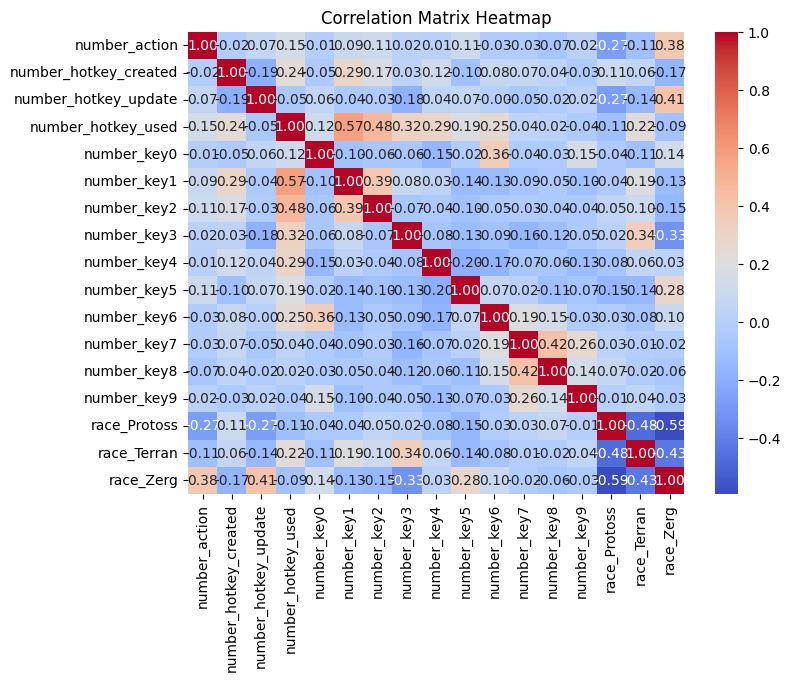

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = X.corr()
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, f1_score

# Define the parameter distributions for random search
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform random search with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, cv=3, scoring='f1_macro', n_iter=40, random_state=42, n_jobs=4)
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model on the test set
best_rf_model = random_search.best_estimator_

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}


In [61]:
y_pred = best_rf_model.predict(X_valid)

In [62]:
# Compute the F1 score
f1 = f1_score(y_valid, y_pred, average= 'macro')

# Print the F1 score
print(f1)

0.8292443248081858


number_key3              0.098409
number_key4              0.095189
number_key2              0.093278
number_key5              0.089054
number_key1              0.088145
number_hotkey_used       0.078103
number_action            0.076828
number_hotkey_created    0.068005
number_key6              0.061426
number_key0              0.059342
number_key8              0.042688
number_key7              0.040421
number_key9              0.037296
number_hotkey_update     0.035448
race_Protoss             0.014287
race_Zerg                0.011358
race_Terran              0.010723
dtype: float64


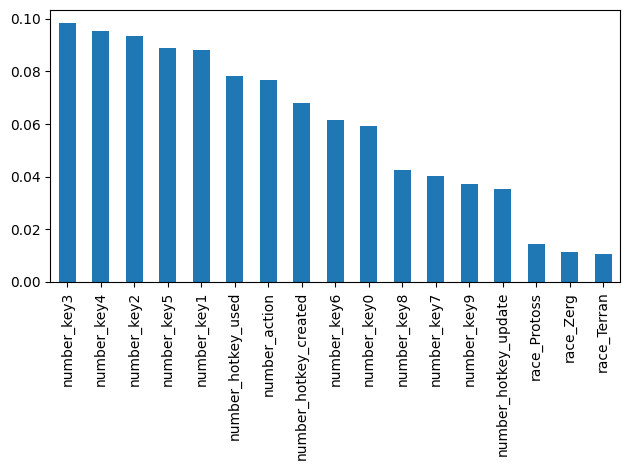

In [63]:
# Feature importances
importances = best_rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf_model.estimators_], axis=0)

feature_names = list(X_train.columns)
forest_importances = pd.Series(importances, index=feature_names)
sorted_importances = forest_importances.sort_values(ascending = False)
print(sorted_importances)

fig, ax = plt.subplots()
sorted_importances.plot.bar(ax=ax)
ax.set_title("")
ax.set_ylabel("")
fig.tight_layout()

In [64]:
# Test data preparation

test_data = "/kaggle/input/projetdm-data/TEST.CSV"
### Loop the data lines
with open(test_data, 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
df_test = pd.read_csv(test_data,header=None, delimiter=",", names=column_names, low_memory=False).astype(str)
df_test.insert(0, '0', 0)
df_test.head()

,0,0,1,2,3,4,5,6,7,8,...,6808,6809,6810,6811,6812,6813,6814,6815,6816,6817
0,0,Zerg,s,s,s,hotkey10,s,hotkey60,s,hotkey00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,Terran,s,hotkey30,hotkey00,t5,s,hotkey32,s,hotkey32,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,Protoss,Base,s,s,Base,s,hotkey20,hotkey30,hotkey60,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,Zerg,s,s,s,s,hotkey20,s,hotkey40,t5,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,Protoss,Base,s,s,Base,s,hotkey50,hotkey30,t5,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [65]:
converted_test_data = df_test.values
output_test_data = extract_features(converted_test_data, is_test=True)

In [66]:
new_test_df = pd.DataFrame(output_test_data, columns=headers)
new_test_df = pd.get_dummies(new_test_df, columns=['race'])
X_test = new_test_df.iloc[:, 1:]  # Features (game information)
predictions = best_rf_model.predict(X_test)
print(predictions)

['http://eu.battle.net/sc2/en/profile/3538115/1/Golden/'
 'http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/'
 'http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/'
 'http://eu.battle.net/sc2/en/profile/250458/1/VortiX/'
 'http://eu.battle.net/sc2/en/profile/950504/1/Grubby/'
 'http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/'
 'http://eu.battle.net/sc2/en/profile/4234852/1/First/'
 'http://eu.battle.net/sc2/en/profile/884897/1/LiquidSnute/'
 'http://eu.battle.net/sc2/en/profile/2526293/1/Krr/'
 'http://eu.battle.net/sc2/en/profile/377576/1/LiquidMaNa/'
 'http://eu.battle.net/sc2/en/profile/284466/1/EGDeMusliM/'
 'http://eu.battle.net/sc2/en/profile/788178/1/Nerchio/'
 'http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/'
 'http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/'
 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/'
 'http://eu.battle.net/sc2/en/profile/3538115/1/Golden/'
 'http://eu.battle.net/sc2/en/profile/377576/1/LiquidMaNa/'
 'http://eu.ba

In [67]:
# Convert predictions to a DataFrame
submission_df = pd.DataFrame({'prediction': predictions})
submission_df['RowId'] = submission_df.index + 1 # Adding row IDs starting from 0

# Reorder the columns with 'RowID' as the first column
submission_df = submission_df[['RowId', 'prediction']]


# Save the DataFrame to a CSV file named 'submissions.csv'
submission_df.to_csv('submissions.csv', index=False)  